In [1]:
! ls /labs/bhasinlab/Shiny_Test/SurvivalGenie/data/TARGET_EXCEL_CLINICAL

TARGET-ALL-P1_clinical_OS.txt	     TARGET-CCSK_clinical_OS.txt
TARGET-ALL-P2-Bcell_clinical_OS.txt  TARGET-NBL_clinical_OS.txt
TARGET-ALL-P2_clinical_OS.txt	     TARGET-OS_clinical_OS.txt
TARGET-ALL-P2-Tcell_clinical_OS.txt  TARGET-RT_clinical_OS.txt
TARGET-ALL-P3_clinical_OS.txt	     TARGET-WT_clinical_OS.txt
TARGET-AML_clinical_OS.txt


In [2]:
! head -3 /labs/bhasinlab/Shiny_Test/SurvivalGenie/data/GDC_FPKM/metastatic/TCGA-BLCA_FPKM.txt
! echo '   '
! head -20 /labs/bhasinlab/Shiny_Test/SurvivalGenie/data/GDC_FPKM/primary/TCGA-LGG_clinical_OS.txt
# ! echo '   '
# ! head -3 /labs/bhasinlab/Shiny_Test/SurvivalGenie/data/GDC_FPKM/metastatic/TCGA-ACC_clinical.txt

ensg	symbol
ENSG00000000003.13	TSPAN6
ENSG00000000005.5	TNMD
   
case_id	submitter_id.x	days_to_last_follow_up	days_to_death	vital_status	Vital.Status	Overall.Survival.Time.in.Days
3e4851ca-4d69-4035-a2dd-8ed6e70f1ffb	TCGA-S9-A6WD_diagnosis	2289	NA	Alive	Alive	2289
2c03e8b9-8856-43a7-853d-5ec51a6e5330	TCGA-DH-5140_diagnosis	NA	607	Dead	Dead	607
491ea65b-86c8-4686-99cf-f09505e20183	TCGA-HT-7693_diagnosis	533	NA	Alive	Alive	533
648252da-dd86-48d1-ae75-4257e3142b0b	TCGA-FG-5964_diagnosis	1588	NA	Alive	Alive	1588
bc3b4816-df1d-44ed-a8c6-f32c8e011a1f	TCGA-HW-8319_diagnosis	660	1209	Dead	Dead	1209
c40ab957-fe46-43b1-992d-b4e2040a3f57	TCGA-FG-7637_diagnosis	1219	NA	Alive	Alive	1219
50975570-c0d5-4ee7-9226-40b3db1bde84	TCGA-VM-A8C9_diagnosis	1314	NA	Alive	Alive	1314
f6a81d81-7df4-4273-8a86-e0cd3b8b1df5	TCGA-S9-A7IS_diagnosis	NA	241	Dead	Dead	241
b027ab77-70eb-4877-91a3-702064d9cc8b	TCGA-HT-7684_diagnosis	184	NA	Alive	Alive	184
442df188-b678-45bb-bd9d-7071ed8aaa5a	TCGA-KT-A74X_diagnosis	438	NA	

In [1]:
import os 
from os import path
import pandas as pd 
import numpy as np
from lifelines import CoxPHFitter
from tqdm import tqdm

In [2]:
FILE_DIR = "/labs/bhasinlab/Shiny_Test/SurvivalGenie/data/"
FPKM_DIR = "GDC_FPKM"
MAF_DIR = "GDC_MAF"
TARGET_DIR = "TARGET_EXCEL_CLINICAL"
# readOSFile <- paste(FILE_DIR, FPKM_DIR, tumor_type, osFile, sep='/')

In [3]:
gene = ["TP53","CD8A"] # sig_gene / user_gene / use as list anyway
datasets = ["TCGA-ACC","TCGA-LGG"]
tumor_type = "primary" # metastatic  primary  recurrent
survival = "overall"
group_method = "cutp"

In [4]:
df_cox = ["Dataset", "HR_Ratio","HR_CI_low", "HR_CI_high", "nlow", "nhigh", "HR", "HR_Pvalue", "Cut_Point", "LR_Pvalue"]
alias1 = ["Dataset", "HR", "HR", "HR", "nLow", "nHigh", "HR", "HR", "Point", "LR"]
alias2 = ["", "Ratio", "CI-lower", "CI-upper", "Cases", "Cases", "(95% CI)", "Pvalue", "Cut", "Pvalue"]

In [ ]:
def cutp_opt(df, survival_type):
    # R file functions/find_cutp.R 
    cph = CoxPHFitter()
    if survival_type == "Overall":
        df["overall_survival_time_in_months"] = df["Overall.Survival.Time.in.Months"]/30.42
        cph.fit(df, duration_col='overall_survival_time_in_months', event_col='vital_status', 
                formula="1 + gx_score") # formula="a + b + c * d"        # cph.print_summary()    
    else: 
        df["overall_survival_time_in_months"] = df["Overall.Survival.Time.in.Months"]/30.42
        cph.fit(df, duration_col='overall_survival_time_in_months', event_col='vital_status', 
                formula="1 + gx_score")
    
    pass

In [5]:
# survival Genie 1 line 5604
for dataset in datasets:
    exp_file = path.join(FILE_DIR,FPKM_DIR,tumor_type,f"{dataset}_FPKM.txt")
    # check file existence
    assert path.isfile(exp_file)
    exp_df = pd.read_csv(exp_file, sep='\t')
    # rename symbol column name 
    exp_df.rename(columns={ exp_df.columns[1]: "symbol" }, inplace = True)
    exp_df["symbol"] = exp_df["symbol"].apply(lambda x: x.upper())
    exp_df.set_index("symbol",inplace=True)
    # exp_df: column names: [symbol, sample_ids,] .... row names: [symbol names,]

    if survival == "overall":
        clinicalos_file = path.join(FILE_DIR,FPKM_DIR,tumor_type,f"{dataset}_clinical_OS.txt")
        # check file existence 
        assert path.isfile(clinicalos_file)
        clinicalos_df = pd.read_csv(clinicalos_file, sep='\t')
        clinicalos_df.rename(columns={ clinicalos_df.columns[1]: "sample_id" }, inplace = True)
        samples = clinicalos_df[(~clinicalos_df["Overall.Survival.Time.in.Days"].isna()) &
                                ~clinicalos_df["vital_status"].isna()]
        samples = samples[samples["vital_status"].isin(["Alive", "Dead"])]
        # samples: colnames: [case id, sample id, days, status], rownames: [sample ids]
        if (samples.shape[0] < 20) or (len(samples["vital_status"].unique()) < 2):
            print("Not enough events for survival analysis")
            break
    else: # event free survival; only apply for TARGET dataset
        clinicalos_file = path.join(FILE_DIR,TARGET_DIR,tumor_type,f"{dataset}_clinical_OS.txt")
        # check file existence 
        assert path.isfile(clinicalos_file)
        clinicalos_df = pd.read_csv(clinicalos_file, sep='\t')
        clinicalos_df.rename(columns={ clinicalos_df.columns[1]: "sample_id" }, inplace = True)
        samples = clinicalos_df[(~clinicalos_df["Event.Free.Survival.Time.in.Days"].isna()) &
                                ~clinicalos_df["First.Event"].isna()]
        samples["first_event"] = samples["First.Event"].astype(str)
        samples["event_status"] = "Event"
        samples[samples["first_event"].isin(["None", "Censored"]) & samples["vital_status"]=="Alive"] = "NoEvent"
        if (samples.shape[0] < 20) or (len(samples["event_status"].unique()) < 2):
            print("Not enough events for survival analysis")
            break
    assert len(samples.sample_id) == len(set(samples.sample_id))
    samples.set_index('sample_id',inplace=True)
    samples["vital_status"] = samples["vital_status"].astype("category")
    samples['vital_status_code'] = samples['vital_status'].cat.codes
    
    # check line 5651
    gene_fpkm = exp_df[exp_df.index.isin(gene)]
    # intersection of gex column names and survival sample ids 
    gene_fpkm = gene_fpkm[list(set(exp_df.columns) & set(samples.index))]
    gene_fpkm = np.log2(gene_fpkm+1)
    assert gene_fpkm.sum().sum() > 0 and gene_fpkm.shape[0] > 0
    
    # Define a score; if one gene just use thexpressio; is multiple genes, use the most variable one
    # ????????????? why ???????????????
    scores = gene_fpkm.T.rename_axis('sample_id', axis=0).rename_axis(None, axis=1)
    # if gene_fpkm.shape[0] > 1: # gene set/multiple gene
    #     scores = scores[[gene_fpkm.index[np.argmax(gene_fpkm.apply(axis=1, func=np.var))]]]
    scores.rename(columns={scores.columns[0]:'gx_score'}, inplace=True)
    print(scores)
    if group_method == "cutp": # separate high / low group with cutp
        sample_score = pd.concat([samples, scores["gx_score"]], axis=1)
        # f = opt_cutp(sample_score, survival_type=survival)
        pass
    else: # separate high/low group with Median, Mean, etc
        pass
    # print(scores)#pd.concat([samples, scores], axis=1))
    break

                        gx_score      CD8A
sample_id                                 
TCGA-OR-A5K3_diagnosis  2.499300  0.242608
TCGA-OR-A5K4_diagnosis  3.377964  0.241218
TCGA-OR-A5K2_diagnosis  3.291412  0.172091
TCGA-OR-A5K9_diagnosis  3.849499  0.195453
TCGA-OR-A5KV_diagnosis  3.832703  1.905271
...                          ...       ...
TCGA-OR-A5J9_diagnosis  3.952252  0.400784
TCGA-PK-A5H9_diagnosis  3.645753  0.688979
TCGA-OR-A5JV_diagnosis  3.038108  0.887177
TCGA-OR-A5K0_diagnosis  3.574059  0.090537
TCGA-OR-A5LR_diagnosis  2.977614  0.426142

[79 rows x 2 columns]


In [6]:
# gene_fpkm.apply(axis=1, func=np.var)
sum(sample_score["gx_score"].isna()) #"Overall.Survival.Time.in.Days" # overall_survival_time_in_months

0

<Axes: xlabel='log(HR) (95% CI)'>

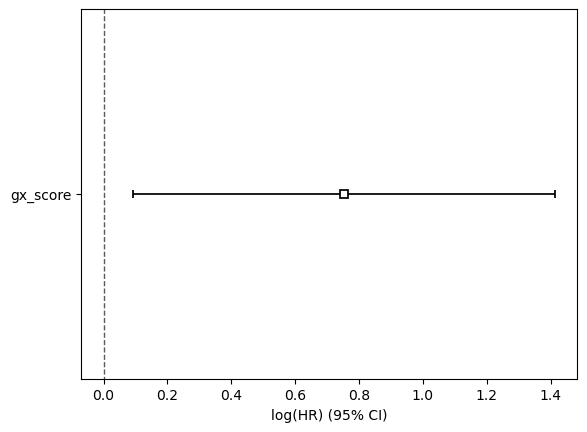

In [73]:
cph = CoxPHFitter()
df = sample_score
# if survival_type == "Overall":
df["overall_survival_time_in_months"] = df["Overall.Survival.Time.in.Days"]/30.42

cph.fit(df, duration_col='overall_survival_time_in_months', event_col='vital_status_code', 
        formula="1 + gx_score") # formula="a + b + c * d"        # cph.print_summary()    
cph.plot()
# else: 
    # df["event_free_survival_time_in_months"] = df["Event.Free.Survival.Time.in.Days"]/30.42
    # cph.fit(df, duration_col='event_free_survival_time_in_months', event_col='vital_status', 
            # formula="1 + gx_score")

In [ ]:
import scipy.stats as ss

def comp_scores(y,method):
    assert method in ["Wilcoxon", "Median", "NormalQuantile", "AnsariBradley", "Savage", "ConSal", "Data"], f"method: {method} not available"
    N=len(y)
    if method =="Wilcoxon":
        return ss.rankdata(y)
    elif method == "Data":
        return y
    elif method=="NormalQuantile":
        return ss.norm.ppf(ss.rankdata(y)/(N+1))
    elif method=="AnsariBradley":
        y_ranks = ss.rankdata(y)
        pmin(r, N - r + 1)
        return 
    elif method=="Median":
             r <- rank(y)
             r[r <= (N+1)/2] <- 0
             r[r > 0] <- 1
             r},
    elif method=="Savage":
        = {
             cscores.Surv(cbind(y, 1)) },
    elif method=="ConSal:
             (rank(y)/(N+1))^4

In [ ]:
def maxstat_test(y,x,weights=None,
                s_method=["Wilcoxon", "Median", "NormalQuantile", "AnsariBradley", "Savage", "ConSal", "Data"],
                p_method=["none", "Lau92", "Lau94", "exactGauss", "HL", "condMC", "min"],
                i_scores=(p_method=="HL"),
                min_prop=.1, max_prop=.9,
                alpha=NULL, keepxy=TRUE):
    # only implement Wilcoxon/none first
    assert s_method in ["Wilcoxon", "Median", "NormalQuantile", "AnsariBradley", "Savage", "ConSal", "Data"], f"s_method: {s_method} not available"
    assert p_method in ["none", "Lau92", "Lau94", "exactGauss", "HL", "condMC", "min"], f"p_method:{p_method} not available"
    assert x, "no data given"
    MULTIMAX = type(x) == pd.DataFrame
    
    scores = 
    pass

In [83]:
def cutpoint(df, time, event, variables, min_prop=.1, pregressbar=True):
    
    # input validation
    assert type(df) == pd.DataFrame, "Input is not a DataFrame"
    assert time in df.columns and event in df.columns, "Specify correct column names containing time and event values."
    assert all([i in df.columns for i in variables]), \
            "Some variables are not found in the data: {}".format(", ".join([i for i in variables if i not in df.columns]))
    #only test on numeric variables
    variables = list(set(variables) & set(df.select_dtypes(include=np.number).columns))
    assert len(variables)>0, "At least, one numeric variables required."
    
    # loop through variables
    surv_data = df[[time, event]].rename(columns={time:"time", event:"event"})
    res = dict
    pregressbar = pregressbar if len(variables > 5) else False
    for var in (tqdm(variables) if pregressbar else variables):
        surv_data["_var"] = df[var]
        # TODO cut = maxstat::maxstat.test
        # res[var] = tmp
    # Return values
    return res

In [ ]:
surv_cutpoint <- function(data, time = "time", event = "event", variables,
                    minprop = 0.1, progressbar = TRUE)
  {
  if(!inherits(data, "data.frame"))
    stop("data should be an object of class data.frame")
  data <- as.data.frame(data)
  if(!all(c(time, event) %in% colnames(data)))
    stop("Specify correct column names containing time and event values.")
  if(!all(variables %in% colnames(data)))
    stop("Some variables are not found in the data: ",
         paste(setdiff(variables, colnames(data)), collapse =", "))

  not_numeric_vars <- .get_not_numeric_vars(data[, variables, drop = FALSE])
  variables <- setdiff(variables, not_numeric_vars) # keep only numeric variables
  if(length(variables)==0) stop("At least, one numeric variables required.")

  nvar <- length(variables)
  if(nvar <= 5) progressbar <- FALSE
  if(progressbar) pb <- utils::txtProgressBar(min = 0, max = nvar, style = 3)
  surv_data <- data.frame(time = data[, time], event = data[, event])
  res <- list()
  for (i in 1:nvar){
    var_i <- variables[i]
    surv_data$var <- data[, var_i]
    max_stat_i <- maxstat::maxstat.test(survival::Surv(time, event) ~ var, data = surv_data,
                                      smethod = "LogRank", pmethod="none",
                                      minprop = minprop, maxprop = 1-minprop,
                                      alpha = alpha)
    res[[var_i]] <- max_stat_i
    if(progressbar) utils::setTxtProgressBar(pb, i)
  }
  colnames(surv_data) <- c(time, event)
  res$data <- cbind.data.frame(surv_data[, 1:2, drop = FALSE], data[, variables, drop = FALSE])
  res$minprop <- minprop
  if(!is.null(not_numeric_vars)) res$not_numeric <- data[, not_numeric_vars, drop = FALSE]
  res <- structure(res, class = c("list", "surv_cutpoint"))
  res$cutpoint <- summary(res)
  res
}